In [1]:
import torch
from torchvision import models
import torchvision.transforms as T
import matplotlib as plt
import numpy as np
import cv2
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Torch using {DEVICE}')

Torch using cuda


In [2]:
model = models.detection.keypointrcnn_resnet50_fpn(
    weights=models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
).eval().to(DEVICE)

In [3]:
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

transforms = T.Compose([
    T.ToTensor()
])

In [4]:
input_image = cv2.cvtColor(cv2.imread(filename='data/dspr_cv_u1_diploma_spr1_3_1.png'), code=cv2.COLOR_BGR2RGB)
transformed_input = transforms(input_image)[None, ...].to(DEVICE)
transformed_input.shape

torch.Size([1, 3, 886, 1300])

In [5]:
output = model(transformed_input)
output

[{'boxes': tensor([[589.0521, 164.7051, 804.7351, 745.0182],
          [496.4953, 396.0961, 524.9779, 433.9488]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9997, 0.1648], device='cuda:0', grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[724.5453, 228.3844,   1.0000],
           [736.7120, 218.4173,   1.0000],
           [715.6968, 217.3098,   1.0000],
           [751.0909, 226.1695,   1.0000],
           [700.2118, 218.4173,   1.0000],
           [762.1516, 287.0803,   1.0000],
           [665.9238, 285.9728,   1.0000],
           [795.3336, 319.1968,   1.0000],
           [639.3781, 363.4955,   1.0000],
           [778.7426, 381.2150,   1.0000],
           [700.2118, 334.7014,   1.0000],
           [720.1210, 447.6631,   1.0000],
           [661.4995, 445.4482,   1.0000],
           [676.9844, 567.2696,   1.0000],
           [685.8329, 567.2696,   1.0000],
           [631.6357, 682.4463,   1.0000],
      

In [6]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

In [28]:
def draw_keypoints_per_person(
    img,
    all_keypoints,
    all_scores,
    confs,
    limbs,
    keypoint_threshold=2, 
    conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.colormaps['rainbow']
    # создаём копию изображений
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
            # итерируем по каждому скору
            # for kp in range(len(scores)):
            #     # проверяем степень уверенности детектора опорной точки
            #     if scores[kp] > keypoint_threshold:
            #         # конвертируем массив ключевых точек в список целых чисел
            #         keypoint = tuple(
            #             map(int, keypoints[kp, :2].cpu())
            #         )
            #         # выбираем цвет
            #         color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
            #         # рисуем кружок радиуса 5 вокруг точки
            #         cv2.circle(img_copy, keypoint, 5, color, -1)
            for joint in limbs:
                if all(map(lambda kp_score: kp_score > keypoint_threshold, scores[joint])):
                    pt1, pt2 = [tuple(map(int, keypoints[joint_idx, :2].cpu())) for joint_idx in joint]
                    cv2.line(img_copy, pt1, pt2, color, 3)
    figure = px.imshow(img_copy, height=img_copy.shape[0], width=img_copy.shape[1])
    figure.show()

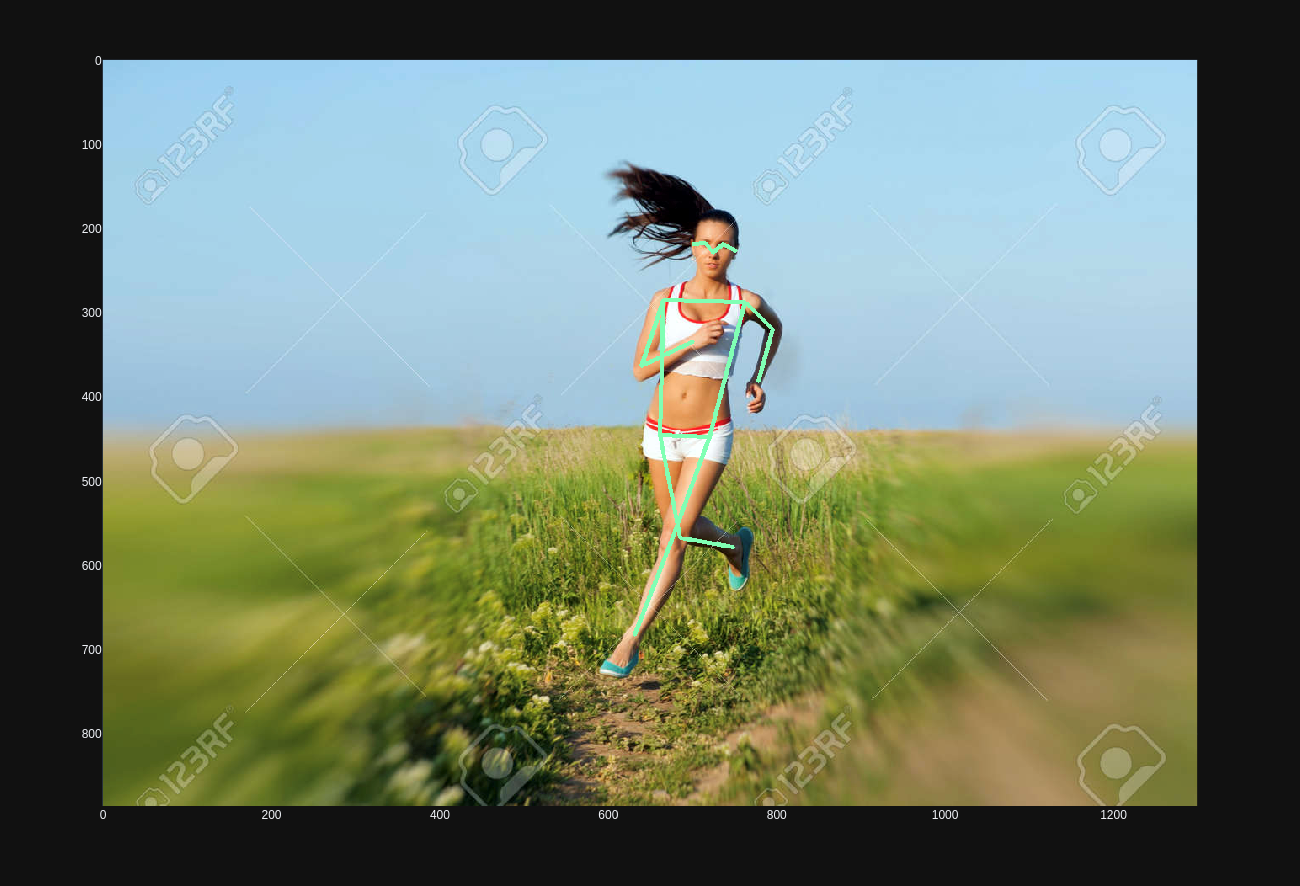

In [29]:
limbs = get_limbs_from_keypoints(keypoints)

draw_keypoints_per_person(
    img=input_image,
    all_keypoints=output[0]['keypoints'],
    all_scores=output[0]['keypoints_scores'],
    confs=output[0]['scores'],
    limbs=limbs
)
